# 0. Введение и описание датасета

- Датасет взят отсюда: https://media.xiph.org/video/derf/. RnD по видеокомпрессии он часто используется для бенчмаркинга алгоритмов. Внизу web-страницы есть разные варианты датасетов, для тестов был взят objective-1-fast. 

- Датасет представляет собой выборку из коротких видео ($~10^2$ фреймов) с разными разрешениями. В них, как правило, нет смены сцены, а значит, можно упростить задачу при тестировании различных подходов для видеокомпрессии. 

- Данные в raw формате yuv420 (.y4m, в отличии от .yuv, есть хэдер с метаданными). Ссылки: https://ru.wikipedia.org/wiki/YUV, 

- Используется opencv-python для загрузки-обработки-сохранения видео.

- В качестве backend-а для i/o используется библиотека ffmpeg. Бинарники для Windows лежат в корне проекта. Для Linux-а нужно ставить отдельно.

- Тензорные разложения делаются с помощью of-the-shelf имплементаций из библиотеки tensorly. Из плюсов, она может использовать PyTorch в качестве backend-a => Можно проводить расчеты на GPU (не реализовано). UPD Реализован налитический подбор рангов TTSVD и HOSVD с использованием нормы Фробениуса. Базовая реализация TTSVD и HOSVD(Tucker) адаптирована из следующей работы: https://github.com/azamat11235/NLRTA


- На текущий момент не было найдено способа сохранять видео обратно в .y4m. Для этого нужно разбираться с CLI ffmpeg (его обертка в opencv этого сделать не позволяет). В текущей реализации, для корректной работы необходимо использовать расширение .avi для сохраняемого файла. При этом формат хранения фреймов видео останется прежним. Следует учитывать, что при конверсии yuv420 - RGB24 - yuv420 есть незначительные потери. Они минимальны и не влияют существенно на результат.

# 1. Чтение, визуализация и запись данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['animation.ffmpeg_path'] = r'ffmpeg/bin/ffmpeg.exe'

In [2]:
LOAD_FNAME = "data/Netflix_PierSeaside_1920x1080_60fps_8bit_420_60f.y4m"
SAVE_FNAME = "compressed_data/Netflix_PierSeaside_1920x1080_60fps_8bit_420_60f.avi"

### 1.1. Загрузка видео в массив numpy

In [3]:
from cvtcomp.io import load_video_to_numpy

video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)

In [4]:
video.shape

(60, 1080, 1920, 3)

 Так можно посмотреть на fourcc исходного видео. https://en.wikipedia.org/wiki/FourCC

In [5]:
import struct
print("FOURCC is '%s'" % struct.pack("<I", int(fourcc)))

FOURCC is 'b'I420''


### 1.2. Визуализация

In [6]:
from cvtcomp.utils import play_video

%matplotlib inline

play_video(video, fps=20)

### 1.3. Сохранение видео в raw формате

In [7]:
from cvtcomp.io import save_video_from_numpy

save_video_from_numpy(SAVE_FNAME, video, fourcc, fps, size, color=True)

### 1.4. Тесты на потери при загрузки/сохранении

Следует учитывать, что есть потери при конверсии y4m -> rgb24 -> y4m 

In [8]:
video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)
save_video_from_numpy(SAVE_FNAME, video, fourcc, fps, size, color=True)
video_new, _, _, _ = load_video_to_numpy(SAVE_FNAME) 

print(f"RMSE: {(((video_new - video)**2).sum() / video_new.size)**0.5}")

RMSE: 2.067145082840086


In [9]:
from cv2 import PSNR

print(f"PSNR = {PSNR(video_new, video)} dB")

video.shape

PSNR = 41.82338443447218 dB


(60, 1080, 1920, 3)

# 2. Тестирование подходов к видеокомпрессии на основе тензорных разложений

In [3]:
LOAD_FNAME = "data/Netflix_PierSeaside_1920x1080_60fps_8bit_420_60f.y4m"
COMPRESSED_VIDEO_FNAME = 'compressed_data/compressed_video.ctv'

## 2.1 Разложение Таккера

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from cvtcomp.base import TensorVideo
from cvtcomp.io import load_video_to_numpy
from cvtcomp.utils import play_video
plt.rcParams['animation.ffmpeg_path'] = r'ffmpeg/bin/ffmpeg.exe'

video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)

tensor_video = TensorVideo(compression_type='tucker', quality=29.0, chunk_size=20, decoded_data_type=np.uint8)

tensor_video.encode(video)

restored_video = tensor_video.decode()

In [13]:
play_video(video, fps=fps / 2)

In [14]:
play_video(restored_video, fps=fps / 2)

In [15]:
from cv2 import PSNR
import os

print(f" CR: { tensor_video.encoded_data_size / os.path.getsize(LOAD_FNAME)}, PSNR: {PSNR(video, restored_video)}") 

 CR: 0.07648945405965629, PSNR: 28.46778629832551


### 2.2 TT-SVD

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from cvtcomp.base import TensorVideo
from cvtcomp.io import load_video_to_numpy
from cvtcomp.utils import play_video
plt.rcParams['animation.ffmpeg_path'] = r'ffmpeg/bin/ffmpeg.exe'

video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)

tensor_video = TensorVideo(compression_type='tt', quality=20.0, chunk_size=60, decoded_data_type=np.uint8)

tensor_video.encode(video)

restored_video = tensor_video.decode()

In [7]:
play_video(video, fps=fps / 2)

In [8]:
play_video(restored_video, fps=fps / 2)

In [9]:
from cv2 import PSNR
import os

print(f" CR: { tensor_video.encoded_data_size / os.path.getsize(LOAD_FNAME)}, PSNR: {PSNR(video, restored_video)}") 

 CR: 0.07598497559965625, PSNR: 23.398382418621722


In [10]:
10 * np.log10(255**2 / ((video.astype(np.float32) - restored_video.astype(np.float32))**2).mean())

23.398383510539208

### 2.3 Использование опорного кадра и сжатие остатков (разностей) для частей видео


Подход вычитанием опорного кадра и компрессии остатков используется в h264 кодеке. Следует проверить, улучшит ли он качество видео при сжатии для используемых форматов хранения сжатого видео

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from cvtcomp.base import TensorVideo
from cvtcomp.io import load_video_to_numpy
from cvtcomp.utils import play_video, delete_reference_frame, restore_from_reference_frame
plt.rcParams['animation.ffmpeg_path'] = r'ffmpeg/bin/ffmpeg.exe'

video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)
substracted_video, ref_frame = delete_reference_frame(video)

tensor_video = TensorVideo(compression_type='tucker', quality=20.0, chunk_size=60, decoded_data_type=np.uint8)
tensor_video.encode(substracted_video)


restored_video = restore_from_reference_frame(tensor_video.decode(), ref_frame)

play_video(restored_video, fps= fps/2)

- Оба подхода работают 
- "Наивная" реализация подхода с компрессией остатков не принесла желаемого результата

### 2.3 Сохранение видео в сжатом формате

In [24]:
tensor_video.save(COMPRESSED_VIDEO_FNAME, fps=30)

### 2.4 Загрузка видео из сжатого формата и его воспроизведение

In [25]:
loaded_tensor_video = TensorVideo().load(COMPRESSED_VIDEO_FNAME)
play_video(loaded_tensor_video.decode(), fps = loaded_tensor_video.fps / 2) # в данном случае загружаем закодированные остатки

## 3. Оценка качества работы алгоритмов по всему датасету

In [21]:
from cvtcomp.utils import compute_metrics_dataset
import numpy as np

def get_metrics_different_qualities(folderpath, compression_type='tt', chunk_size=30, qs=[5.0, 10.0, 20.0, 25.0]):
    
    result = np.array([compute_metrics_dataset(folderpath,
                                                   compression_type=compression_type,
                                                   chunk_size=chunk_size,
                                                   quality=q) for q in qs])
    
    return result[:, 0], result[:, 1], result[:, 2] # CR, PSNR, SSIM

In [20]:
# Получаем  СR, PSNR, SSIM для одного значения quality
compute_metrics_dataset("data/", compression_type='tt', chunk_size=30, quality=5.)

  0%|                                                                                           | 0/30 [00:32<?, ?it/s]


KeyboardInterrupt: 

In [22]:
cr_tt, psnr_tt, ssim_tt = get_metrics_different_qualities(
    'data/',
    compression_type='tt',
    chunk_size=30,
    qs=[5.0, 10.0, 20.0, 25.0, 30.0]
)

print(f"cr_tt: {cr_tt}\n psnr_tt: {psnr_tt}, \n ssim_tt: {ssim_tt}")

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [1:30:48<00:00, 181.61s/it]


cr_tt: [1.60904947e-04 2.81804038e-03 1.56176618e-01 5.28864071e-01
 1.25632606e+00]
 psnr_tt: [15.44509748 16.7193326  23.46841186 26.51888692 31.41276161], 
 ssim_tt: [0.43187077 0.46151141 0.75413323 0.86995214 0.94103364]


In [23]:
cr_tucker, psnr_tucker, ssim_tucker = get_metrics_different_qualities(
    'data/',
    compression_type='tucker',
    chunk_size=30,
    qs=[5.0, 10.0, 20.0, 25.0, 30.0]
)

print(f"cr_tucker: {cr_tucker}\n psnr_tucker: {psnr_tucker} \n ssim_tucker: {ssim_tucker}")

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [44:53<00:00, 89.80s/it]

cr_tucker: [1.50915068e-04 1.53351650e-04 6.79188608e-03 5.65285579e-02
 3.02638887e-01]
 psnr_tucker: [15.41278195 15.41278837 19.6188556  24.32444052 28.42467394] 
 ssim_tucker: [0.43120755 0.43120727 0.54083999 0.7076354  0.84636404]


In [24]:
ssim_h264 = 0.828920385
cr_h264 = 0.007438296
psnr_h264 = 29.37835946

#### CR - PSNR

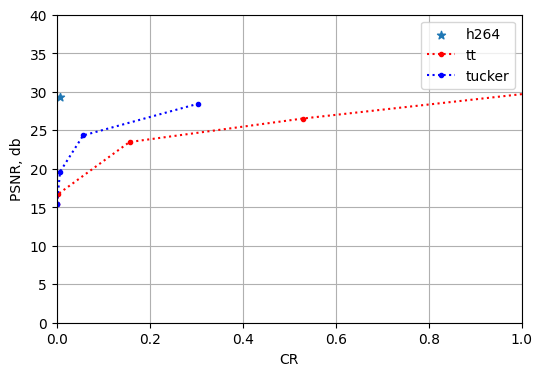

In [25]:
plt.figure(figsize=(6,4))
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 40])
plt.xlabel("CR")
plt.ylabel("PSNR, db")
plt.scatter(cr_h264, psnr_h264, marker='*', label="h264")
plt.plot(cr_tt, psnr_tt, "r:.", label="tt")
plt.plot(cr_tucker, psnr_tucker, "b:.", label="tucker")
plt.legend()

#### CR - SSIM

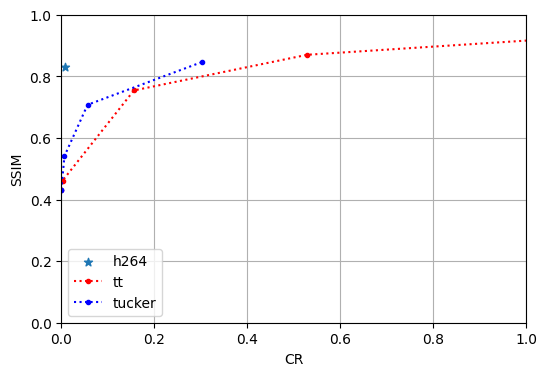

In [26]:
plt.figure(figsize=(6,4))
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("CR")
plt.ylabel("SSIM")

plt.scatter(cr_h264, ssim_h264, marker='*', label="h264")
plt.plot(cr_tt, ssim_tt, "r:.", label="tt")
plt.plot(cr_tucker, ssim_tucker, "b:.", label="tucker")
plt.legend()